In [2]:
%reload_ext autoreload
%autoreload 2
from spice_net import *
from helpers import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Prelim

### Building a toy netlist with diodes

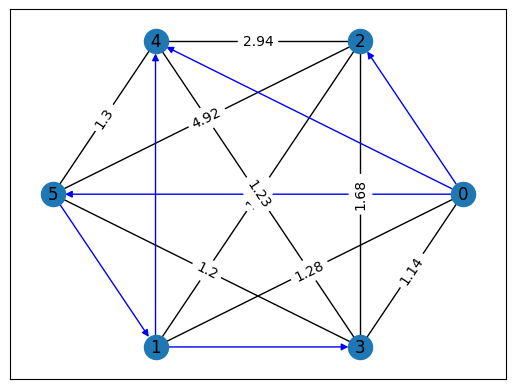

In [3]:
G = nx.erdos_renyi_graph(n=6, p=1)
thresh = 0.5
for u, v in G.edges():
    if np.random.rand() > thresh:
        G[u][v]['type'] = 'diode'
        if np.random.rand() > 0.5:
            G[u][v]['to'] = v
        else:
            G[u][v]['to'] = u
    else:
        G[u][v]['type'] = 'resistor'
        G[u][v]['weight'] = 1/np.random.rand()

vd = NonLinearNetwork('voltage_divider', con_graph=G, node_cfg=(np.array([]), np.array([])), epsilon=1e-16)
visualize(vd)

### Looking at inputs, outputs, and updates on toy dataset

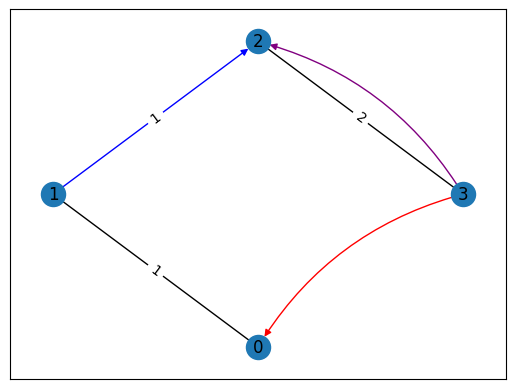

In [560]:
test_G = nx.Graph()
test_G.add_nodes_from(list(range(4)))
test_G.add_edge(0, 1, type='resistor', weight=1)
test_G.add_edge(1, 2, type='diode', weight=1)
test_G.add_edge(2, 3, type='resistor', weight=2)
test = NonLinearNetwork('test', test_G, node_cfg=([[0, 3]], [[2, 3]]))
visualize(test)

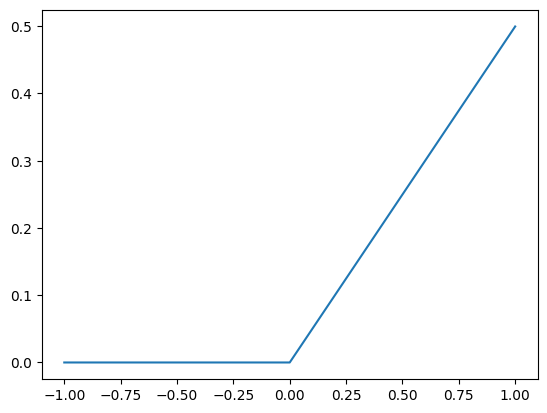

In [561]:
plt.plot(*zip(*[[i, test.predict([i])] for i in np.linspace(-1, 1, 51)]))
plt.show()

### Handmade absolute value function example

#### Generate Dataset

In [570]:
# Generate N random points
N = 50
split = 0.8
pts = np.random.rand(N)
sigma = 0.001

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split), None], pts[int(N*split):, None]

# Generate categories with nonlinear decision boundary
m = np.random.random()
# b = np.random.random()
b = 0

# model = (lambda m, b: lambda x: np.sqrt(m*x + b))(m, b)
model = (lambda m, b: lambda x: np.abs(m*x + b))(m, b)

training['y'] = model(training['x']) + np.random.normal(0, sigma, training['x'].shape)
test['y'] = model(test['x']) + np.random.normal(0, sigma, test['x'].shape)

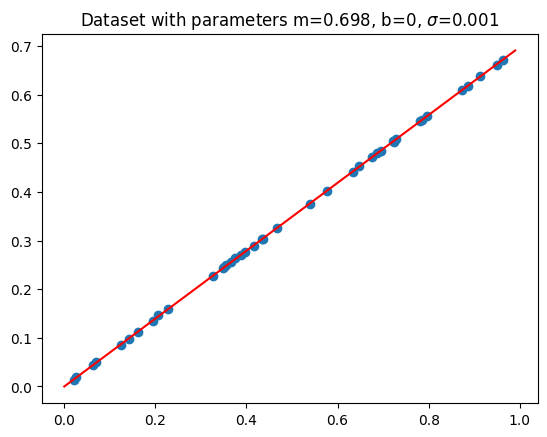

In [571]:
# Visualize dataset
plt.scatter(training['x'], training['y'])
xs = np.arange(0, 1, 0.01)
plt.plot(xs, model(xs), 'r',)
plt.title(fr'Dataset with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

#### Handmake network to learn absolute value

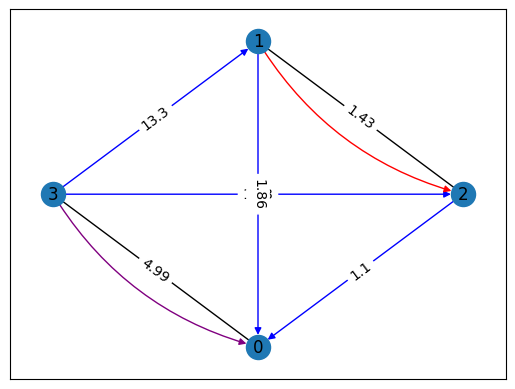

In [585]:
con_graph = nx.DiGraph()
con_graph.add_nodes_from(list(range(4)))

con_graph.add_edge(2, 1, type='resistor', weight=1./np.random.rand())
con_graph.add_edge(0, 3, type='resistor', weight=1./np.random.rand())

con_graph.add_edge(3, 1, type='diode', weight=1./np.random.rand())
con_graph.add_edge(2, 0, type='diode', weight=1./np.random.rand())
con_graph.add_edge(1, 0, type='diode', weight=1./np.random.rand())
con_graph.add_edge(3, 2, type='diode', weight=1./np.random.rand())

node_cfg = [[[2, 1]], [[0, 3]]]

handmade = NonLinearNetwork('handmade', con_graph, node_cfg)
visualize(handmade)

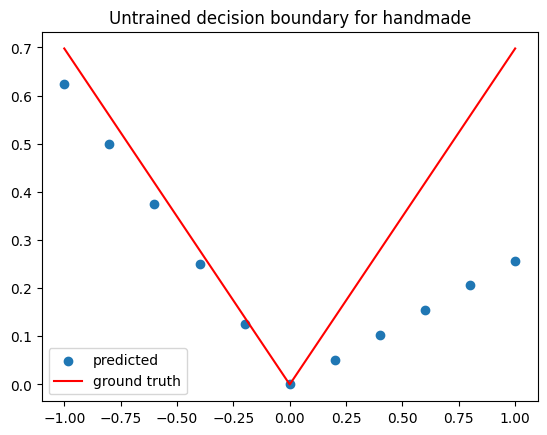

In [586]:
lh = 1
num_pts = 11
xs = np.linspace(-lh, lh, num_pts)
ys = [handmade.predict([x]) for x in xs]
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

In [587]:
# Train linear network
epochs = 5
trained_handmade, loss, updates, weights = train(handmade, xs[:,None], model(xs[:, None]), epochs, gamma=100, eta=0.1)

Epoch 1: 0.01503149464318778
Epoch 2: 0.0184210884358391
Epoch 3: 0.03965819383668427
Epoch 4: 0.013769216469435406
Epoch 5: 0.006942719762137461


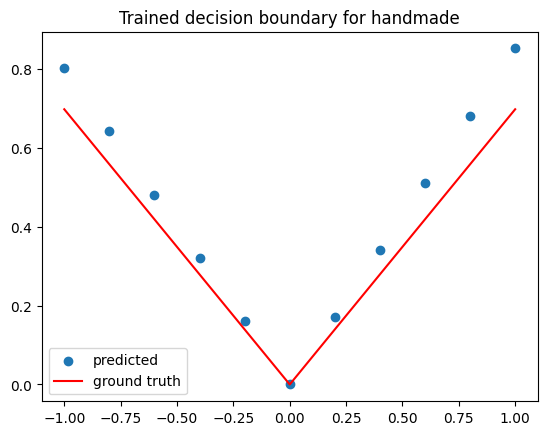

In [589]:
ys = [trained_handmade.predict([x]) for x in xs]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

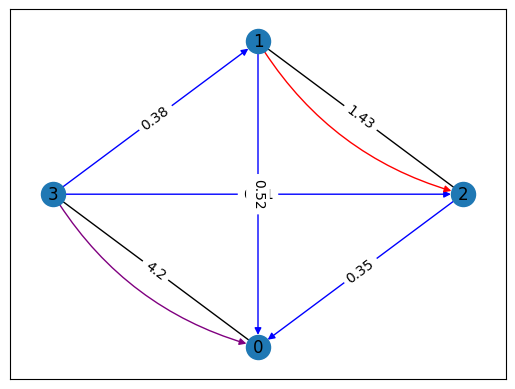

In [590]:
visualize(trained_handmade)

## Training on a nonlinear function

### Generate the dataset

In [740]:
# Generate N random points
N = 30
split = 1.
# pts = np.random.rand(N)
pts = np.linspace(0, 1, N)
sigma = 0.000

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split), None], pts[int(N*split):, None]

# Generate noninear data
m = 2
b = 1e-1

model = (lambda m, b: lambda x: np.log(m*x + b))(m, b)
# model = (lambda m, b: lambda x: np.abs(m*x + b))(m, b)

training['y'] = model(training['x']) + np.random.normal(0, sigma, training['x'].shape)
test['y'] = model(test['x']) + np.random.normal(0, sigma, test['x'].shape)

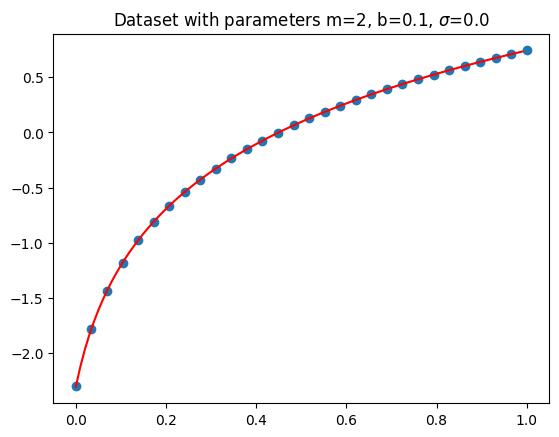

In [741]:
# Visualize dataset
plt.scatter(training['x'], training['y'])
xs = np.arange(0, 1, 0.01)
plt.plot(xs, model(xs), 'r',)
plt.title(fr'Dataset with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

### Nonlinear, no bias voltages

#### Generate random resistor + diode network

In [660]:
# Parameters
nodes = 15
edge_prob = .5
diode_prob = .9

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=True)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() 
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand() 
        res += 1

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

in_nodes = 1
out_nodes = 1
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 114
Num purely resistor: 6
Num diodes: 108


(array([[13,  9]]), array([[12,  6]]))

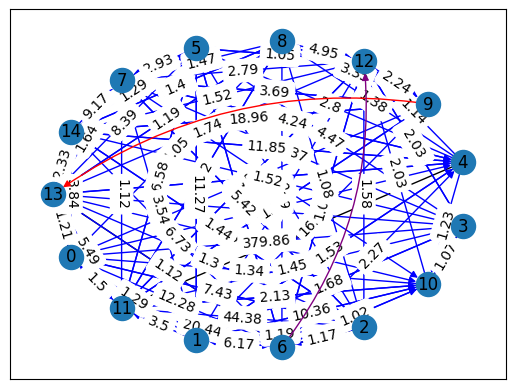

In [661]:
nonlin = NonLinearNetwork('nonlinear', con_graph, node_cfg)
visualize(nonlin)

/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_36363/3163626700.py:18: RuntimeWarning: invalid value encountered in sqrt
  model = (lambda m, b: lambda x: np.sqrt(m*x + b))(m, b)


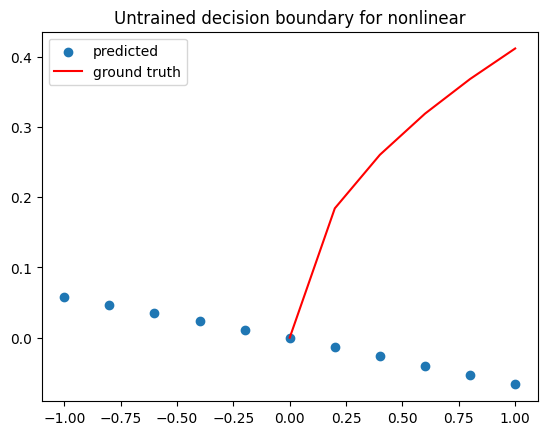

In [662]:
test_net = nonlin
lh = 1
num_pts = 11
xs = np.linspace(-lh, lh, num_pts)
ys = [test_net.predict([x]) for x in xs]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train network

In [663]:
# Train nonlinear network
epochs = 5
trained_nonlin, loss, updates, weights = train(nonlin, training['x'], training['y'], epochs, gamma=10, eta=0.1)

Epoch 1: 0.027373280488933165
Epoch 2: 0.003973238096912308
Epoch 3: 0.0036044595075758424
Epoch 4: 0.0033952474748617065
Epoch 5: 0.005059927063803824


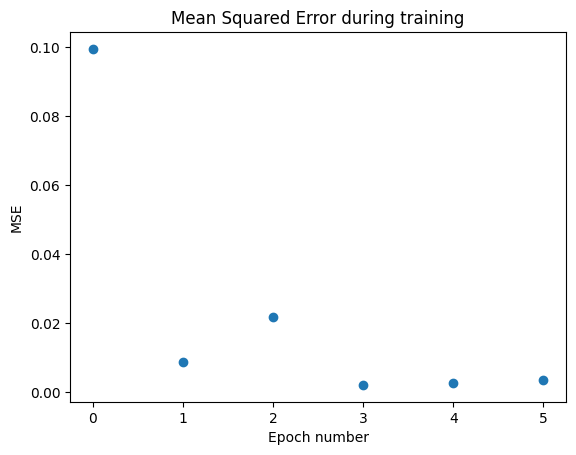

In [648]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

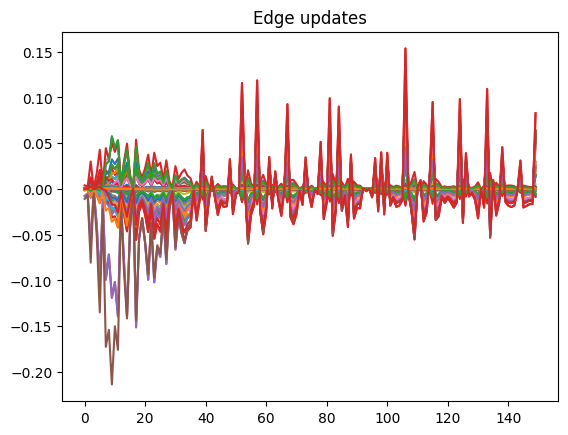

In [664]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

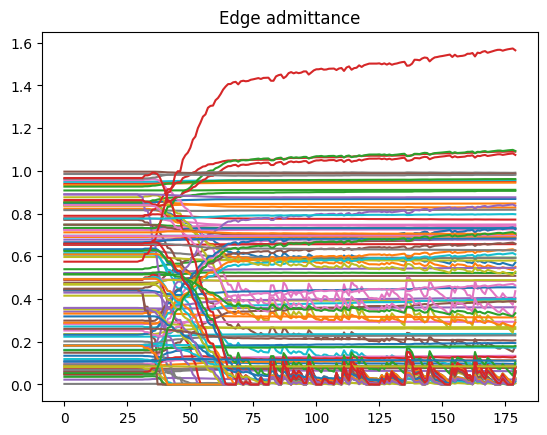

In [665]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

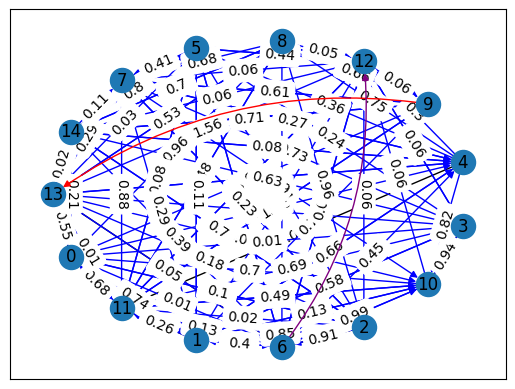

In [666]:
visualize(trained_nonlin, mode='y')

/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_36363/3163626700.py:18: RuntimeWarning: invalid value encountered in sqrt
  model = (lambda m, b: lambda x: np.sqrt(m*x + b))(m, b)


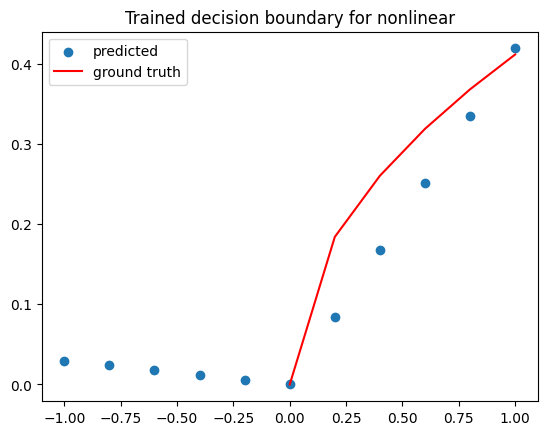

In [667]:
test_net = nonlin
ys = [test_net.predict([x]) for x in xs]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()

### Visualize training results over time

/var/folders/p1/kynpdwyn2r5fmbpnr8d45m340000gn/T/ipykernel_36363/396495528.py:17: RuntimeWarning: invalid value encountered in sqrt
  model = (lambda m, b: lambda x: np.sqrt(m*x + b))(m, b)


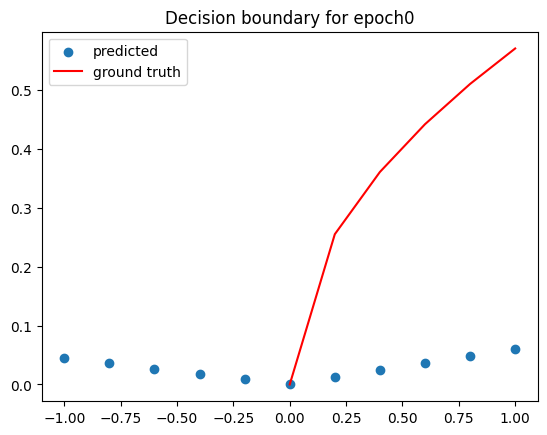

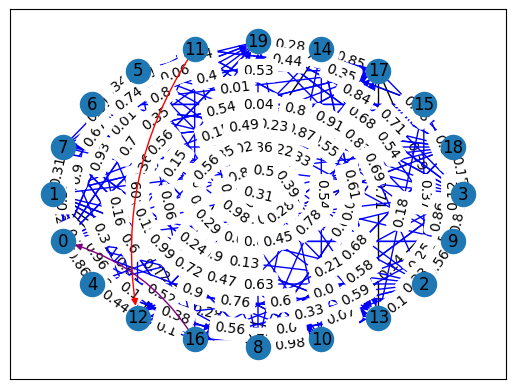

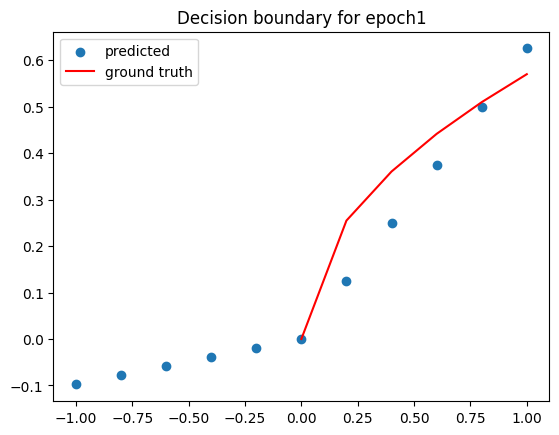

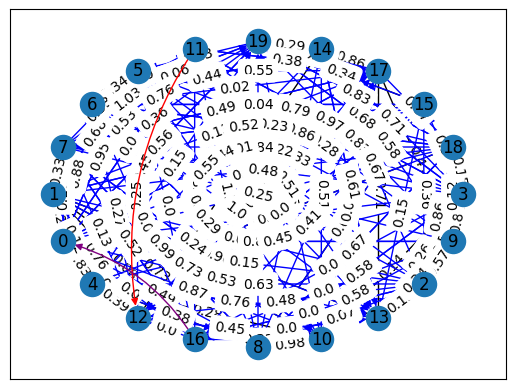

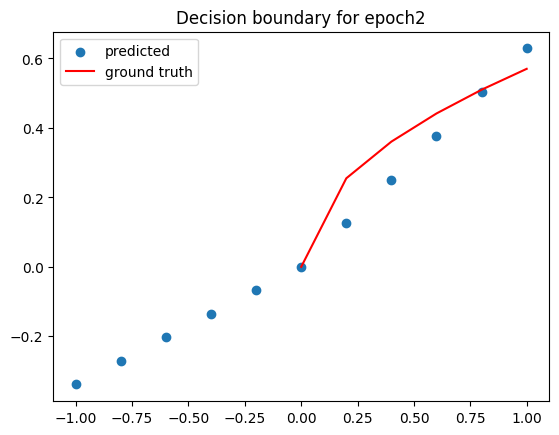

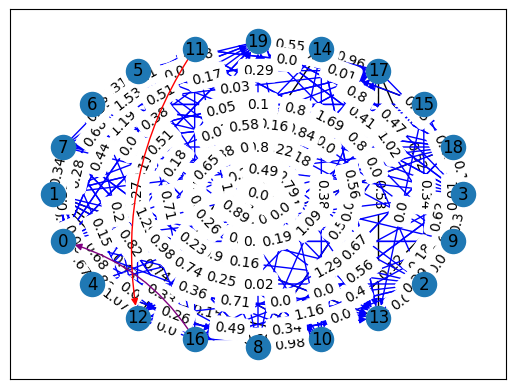

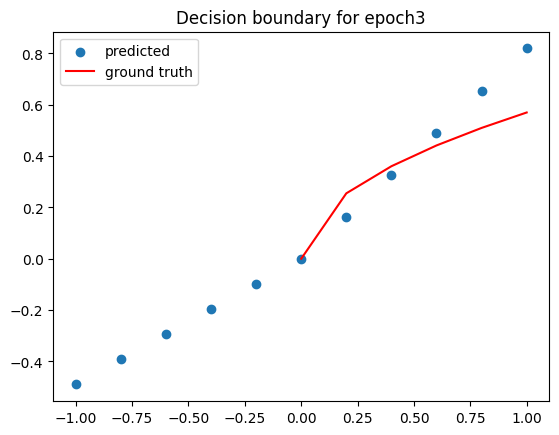

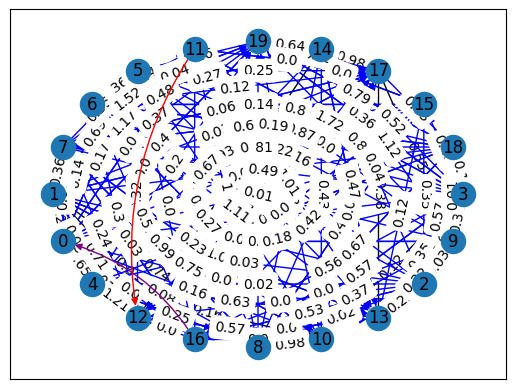

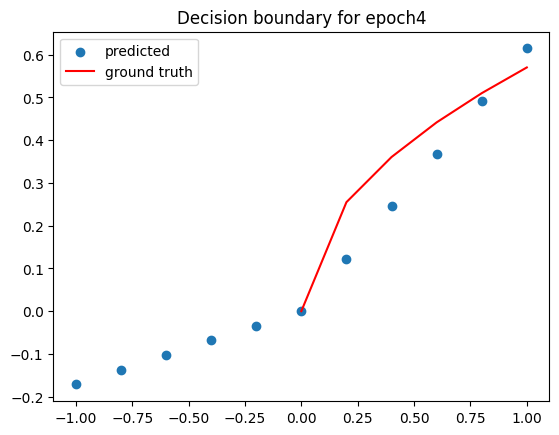

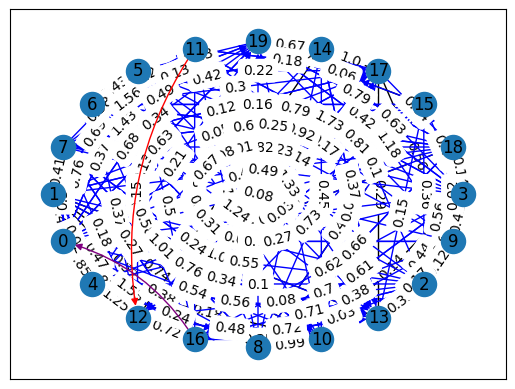

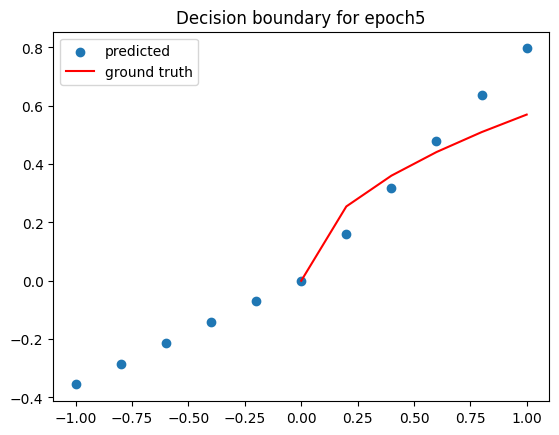

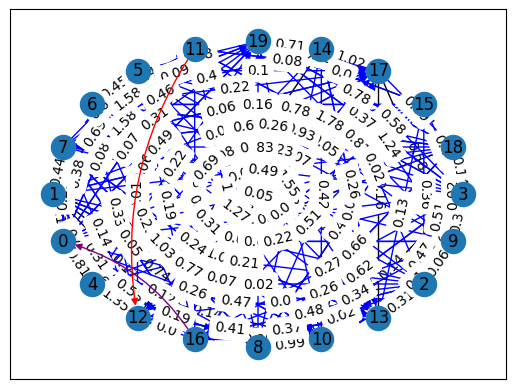

In [608]:
test_net: NonLinearNetwork = nonlin.copy(f'test_net')
for test_it in range(epochs+1):
    for i, R in enumerate(test_net.edges):
        R.resistance = weights[test_it, 0][i]

    for i, X in enumerate(test_net.nonlinear_vals):
        X.R1.resistance = weights[test_it, 0][i + len(test_net.edges)]
    lh = 1
    num_pts = 11
    xs = np.linspace(-lh, lh, num_pts)
    ys = [test_net.predict([x]) for x in xs]

    plt.scatter(xs, ys)
    plt.plot(xs, model(xs), 'r')
    plt.title(f'Decision boundary for epoch{test_it}')
    plt.legend(['predicted', 'ground truth'])
    plt.show()
    visualize(test_net, mode='y')
    plt.show()

### Retry example with bias terms

In [757]:
# Parameters
nodes = 20
edge_prob = .6
diode_prob = .9

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=True)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() 
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand() 
        res += 1

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

in_nodes = 2
out_nodes = 1
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 236
Num purely resistor: 21
Num diodes: 215


(array([[ 8, 12],
        [ 5, 11]]),
 array([[ 7, 18]]))

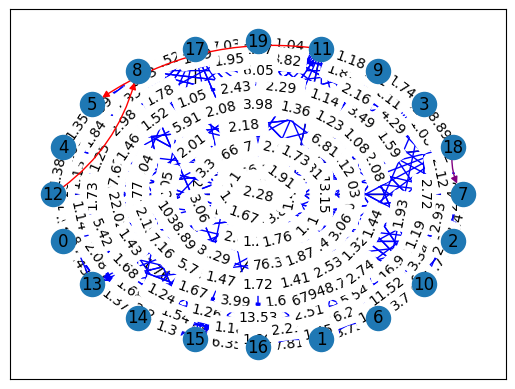

In [758]:
nonlin = NonLinearNetwork('nonlinear', con_graph, node_cfg)
visualize(nonlin)

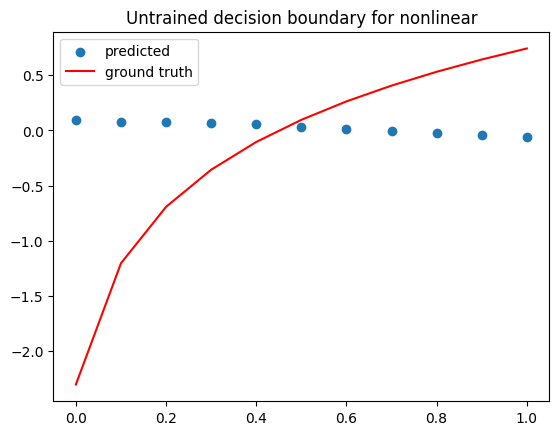

In [744]:
test_net = nonlin
lh = 1
num_pts = 11
xs = np.linspace(0, lh, num_pts)
ys = [test_net.predict([x, 1]) for x in xs]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train network

In [751]:
# Train nonlinear network
epochs = 10
training_bias = np.hstack((training['x'], np.ones((training['x'].shape[0], 1))))
trained_nonlin, loss, updates, weights = train(nonlin, training_bias, training['y'], epochs, gamma=10, eta=0.1)

Epoch 1: 0.40447434294590423
Epoch 2: 0.3898212966563757
Epoch 3: 0.384573881556172
Epoch 4: 0.38435778259818487
Epoch 5: 0.385938849846655
Epoch 6: 0.38042726874455685
Epoch 7: 0.36568571096233876
Epoch 8: 0.3411903608624629
Epoch 9: 0.3902740277374025
Epoch 10: 0.36648266912599436


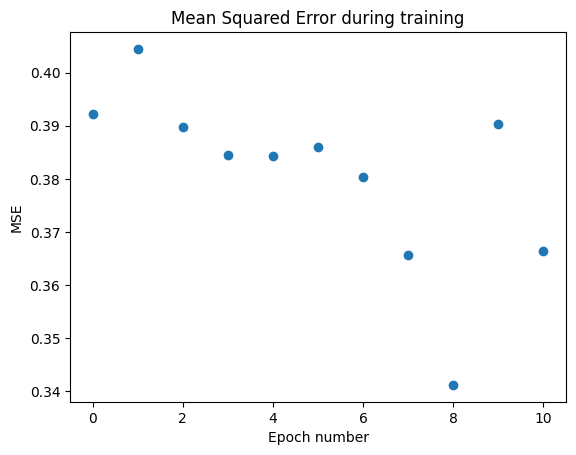

In [752]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

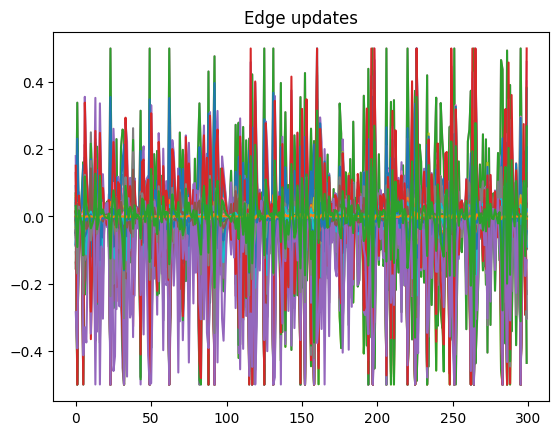

In [753]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

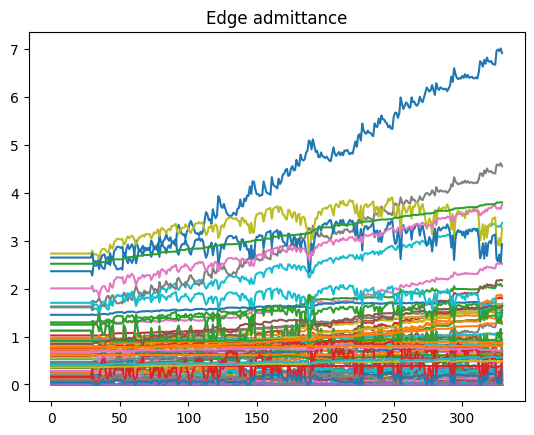

In [754]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

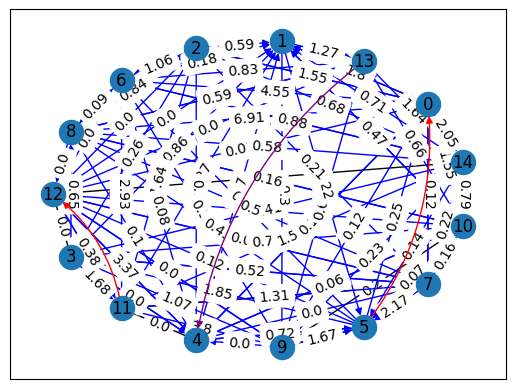

In [755]:
visualize(trained_nonlin, mode='y')

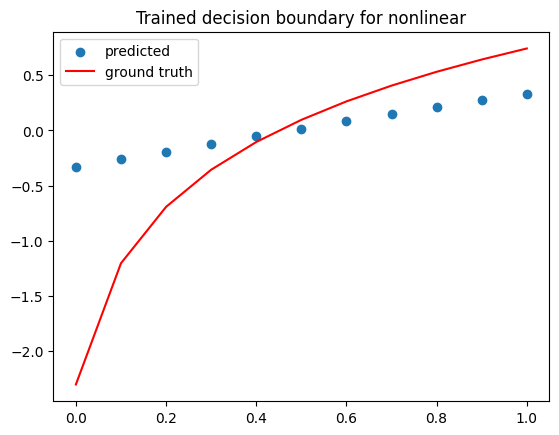

In [756]:
test_net = nonlin
ys = [test_net.predict([x, 1]) for x in xs]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()